# RAG Pipeline with Gemini
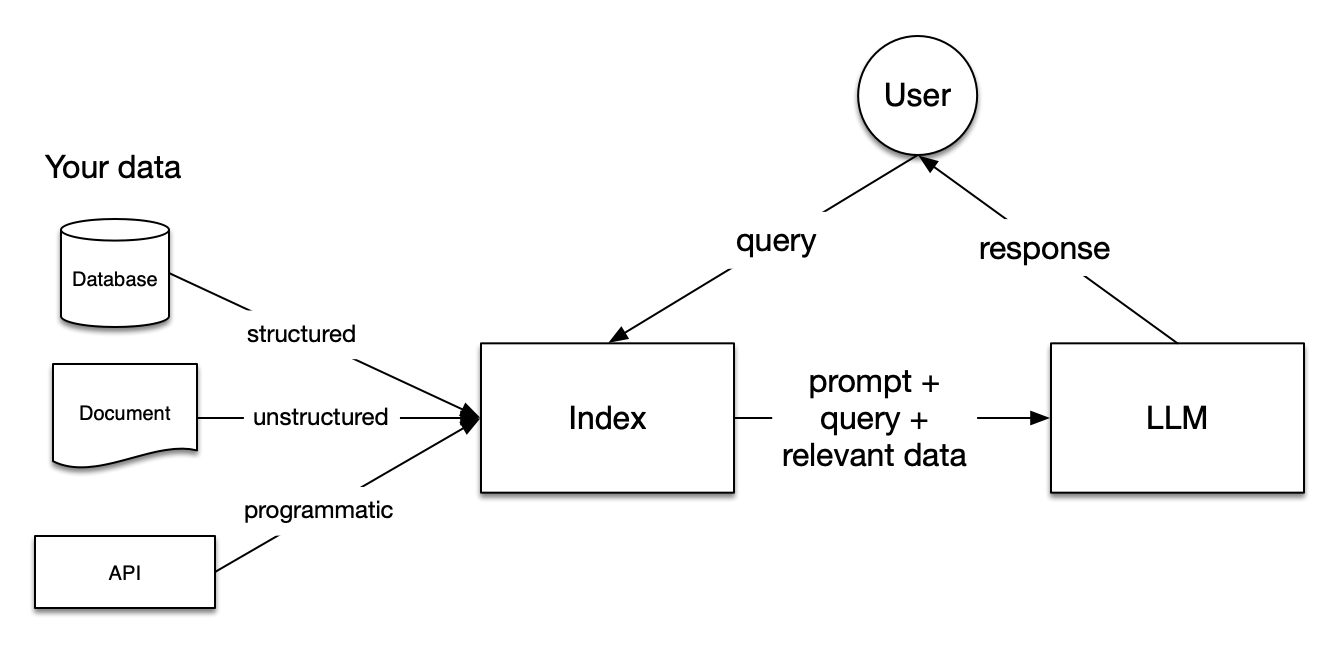
## Installing Dependencies

In [29]:
!pip install llama-index-llms-gemini
!pip install -q llama-index google-generativeai
!pip install python-dotenv
!pip install spacy
!pip install -q cohere llama-index-postprocessor-cohere-rerank

## Importing Libraries

In [30]:
# for env var
import os
from dotenv import load_dotenv

# for Gemini
from llama_index.llms.gemini import Gemini

## Set LLM
from llama_index.core import Settings

# Import custom embedding model for Hugging face
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# For chunking
from llama_index.core.node_parser import SentenceSplitter

# Get vector embeddings anf read from PDFs
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

# Store Vector Embeddings
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext

# For Querying 
from llama_index.core import get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor,KeywordNodePostprocessor

## Get environment variables

In [31]:
from dotenv import load_dotenv

load_dotenv()
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY",'')

## Set the LLM

In [32]:
Settings.llm=llm = Gemini(model="models/gemini-pro")

## Set the Embedding Model

In [33]:
from llama_index.embeddings.gemini import GeminiEmbedding

model_name = "models/embedding-001"

Settings.embed_model  = GeminiEmbedding(
    model_name=model_name, api_key=GOOGLE_API_KEY, title="this is a document"
)


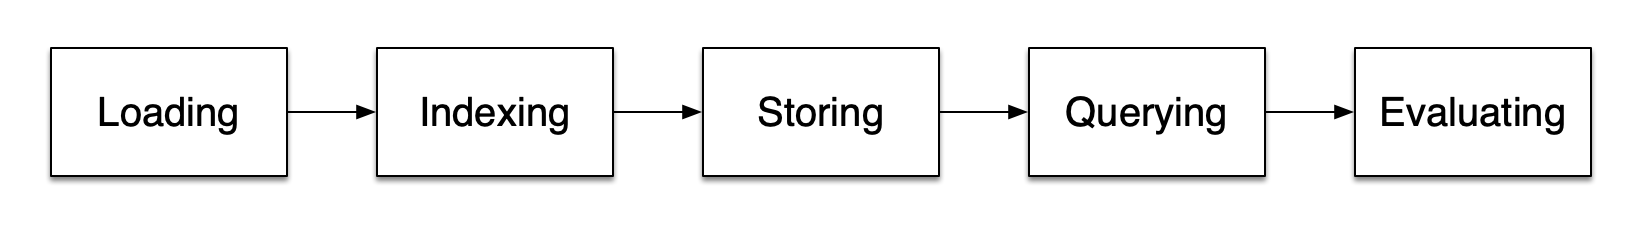

## Reading the documents

In [28]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("./data").load_data()

## Chunking and storing

In [34]:
text_splitter = SentenceSplitter(chunk_size=2000, chunk_overlap=200)

Settings.text_splitter = text_splitter

db = chromadb.PersistentClient(path="./chroma_db")

# get collection
chroma_collection = db.get_or_create_collection("research_papers")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)


# per-index
index = VectorStoreIndex.from_documents(
    documents, transformations=[text_splitter], storage_context=storage_context
)

## Getting Stored vectors from DB

In [18]:
# initialize client
db = chromadb.PersistentClient(path="./chroma_db")

# get collection
chroma_collection = db.get_or_create_collection("research_papers")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# load your index from stored vectors
index = VectorStoreIndex.from_vector_store(
    vector_store, storage_context=storage_context
)

## Query the engine 

In [19]:
from llama_index.core.response_synthesizers import ResponseMode

# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10,
)

# configure response synthesizer
response_synthesizer = get_response_synthesizer(
    response_mode=ResponseMode.COMPACT_ACCUMULATE
    
)

node_postprocessors = [
    KeywordNodePostprocessor(
        required_keywords=["author,names,researcher"], exclude_keywords=["Italy"]
    ),
    SimilarityPostprocessor(similarity_cutoff=0.2),
] 

# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.4)],
)



In [20]:
# from llama_index.core.data_structs import Node
# from llama_index.core.response_synthesizers import ResponseMode
# from llama_index.core import get_response_synthesizer
response = query_engine.query("What problem is this paper addressing, and how does it solve it?, what are the results ?")

# response = response_synthesizer.synthesize(
#     "What problem is this paper addressing?", nodes=[Node(text="text"), ...]
# )
print(response)


Response 1: This paper addresses the problem of comparing the performance of different Large Language Models (LLMs) for code synthesis. It proposes a methodology that consists of four phases: selecting the right prompt, checking functional validity, checking technical quality, and human evaluation. The methodology aims to provide a fair and comprehensive comparison of LLMs by considering factors such as prompt engineering, functional correctness, technical quality, and human judgment. The results of the methodology are not provided in the given context.


## Reranking
## Query Pipelines
Query pipelines are used to process and analyze user queries in a structured manner. They consist of a series of steps that transform and manipulate the query data to generate relevant results.

## Parsers
Parsers are tools or libraries that are used to extract structured information from unstructured data. They help in converting raw data into a structured format that can be easily analyzed and processed.

## Unstructured Parser
An unstructured parser is a specific type of parser that is designed to handle unstructured data. It is used to extract meaningful information from unstructured sources such as text documents, web pages, or emails. The unstructured parser analyzes the data and identifies patterns or structures within it, making it easier to work with and extract valuable insights.

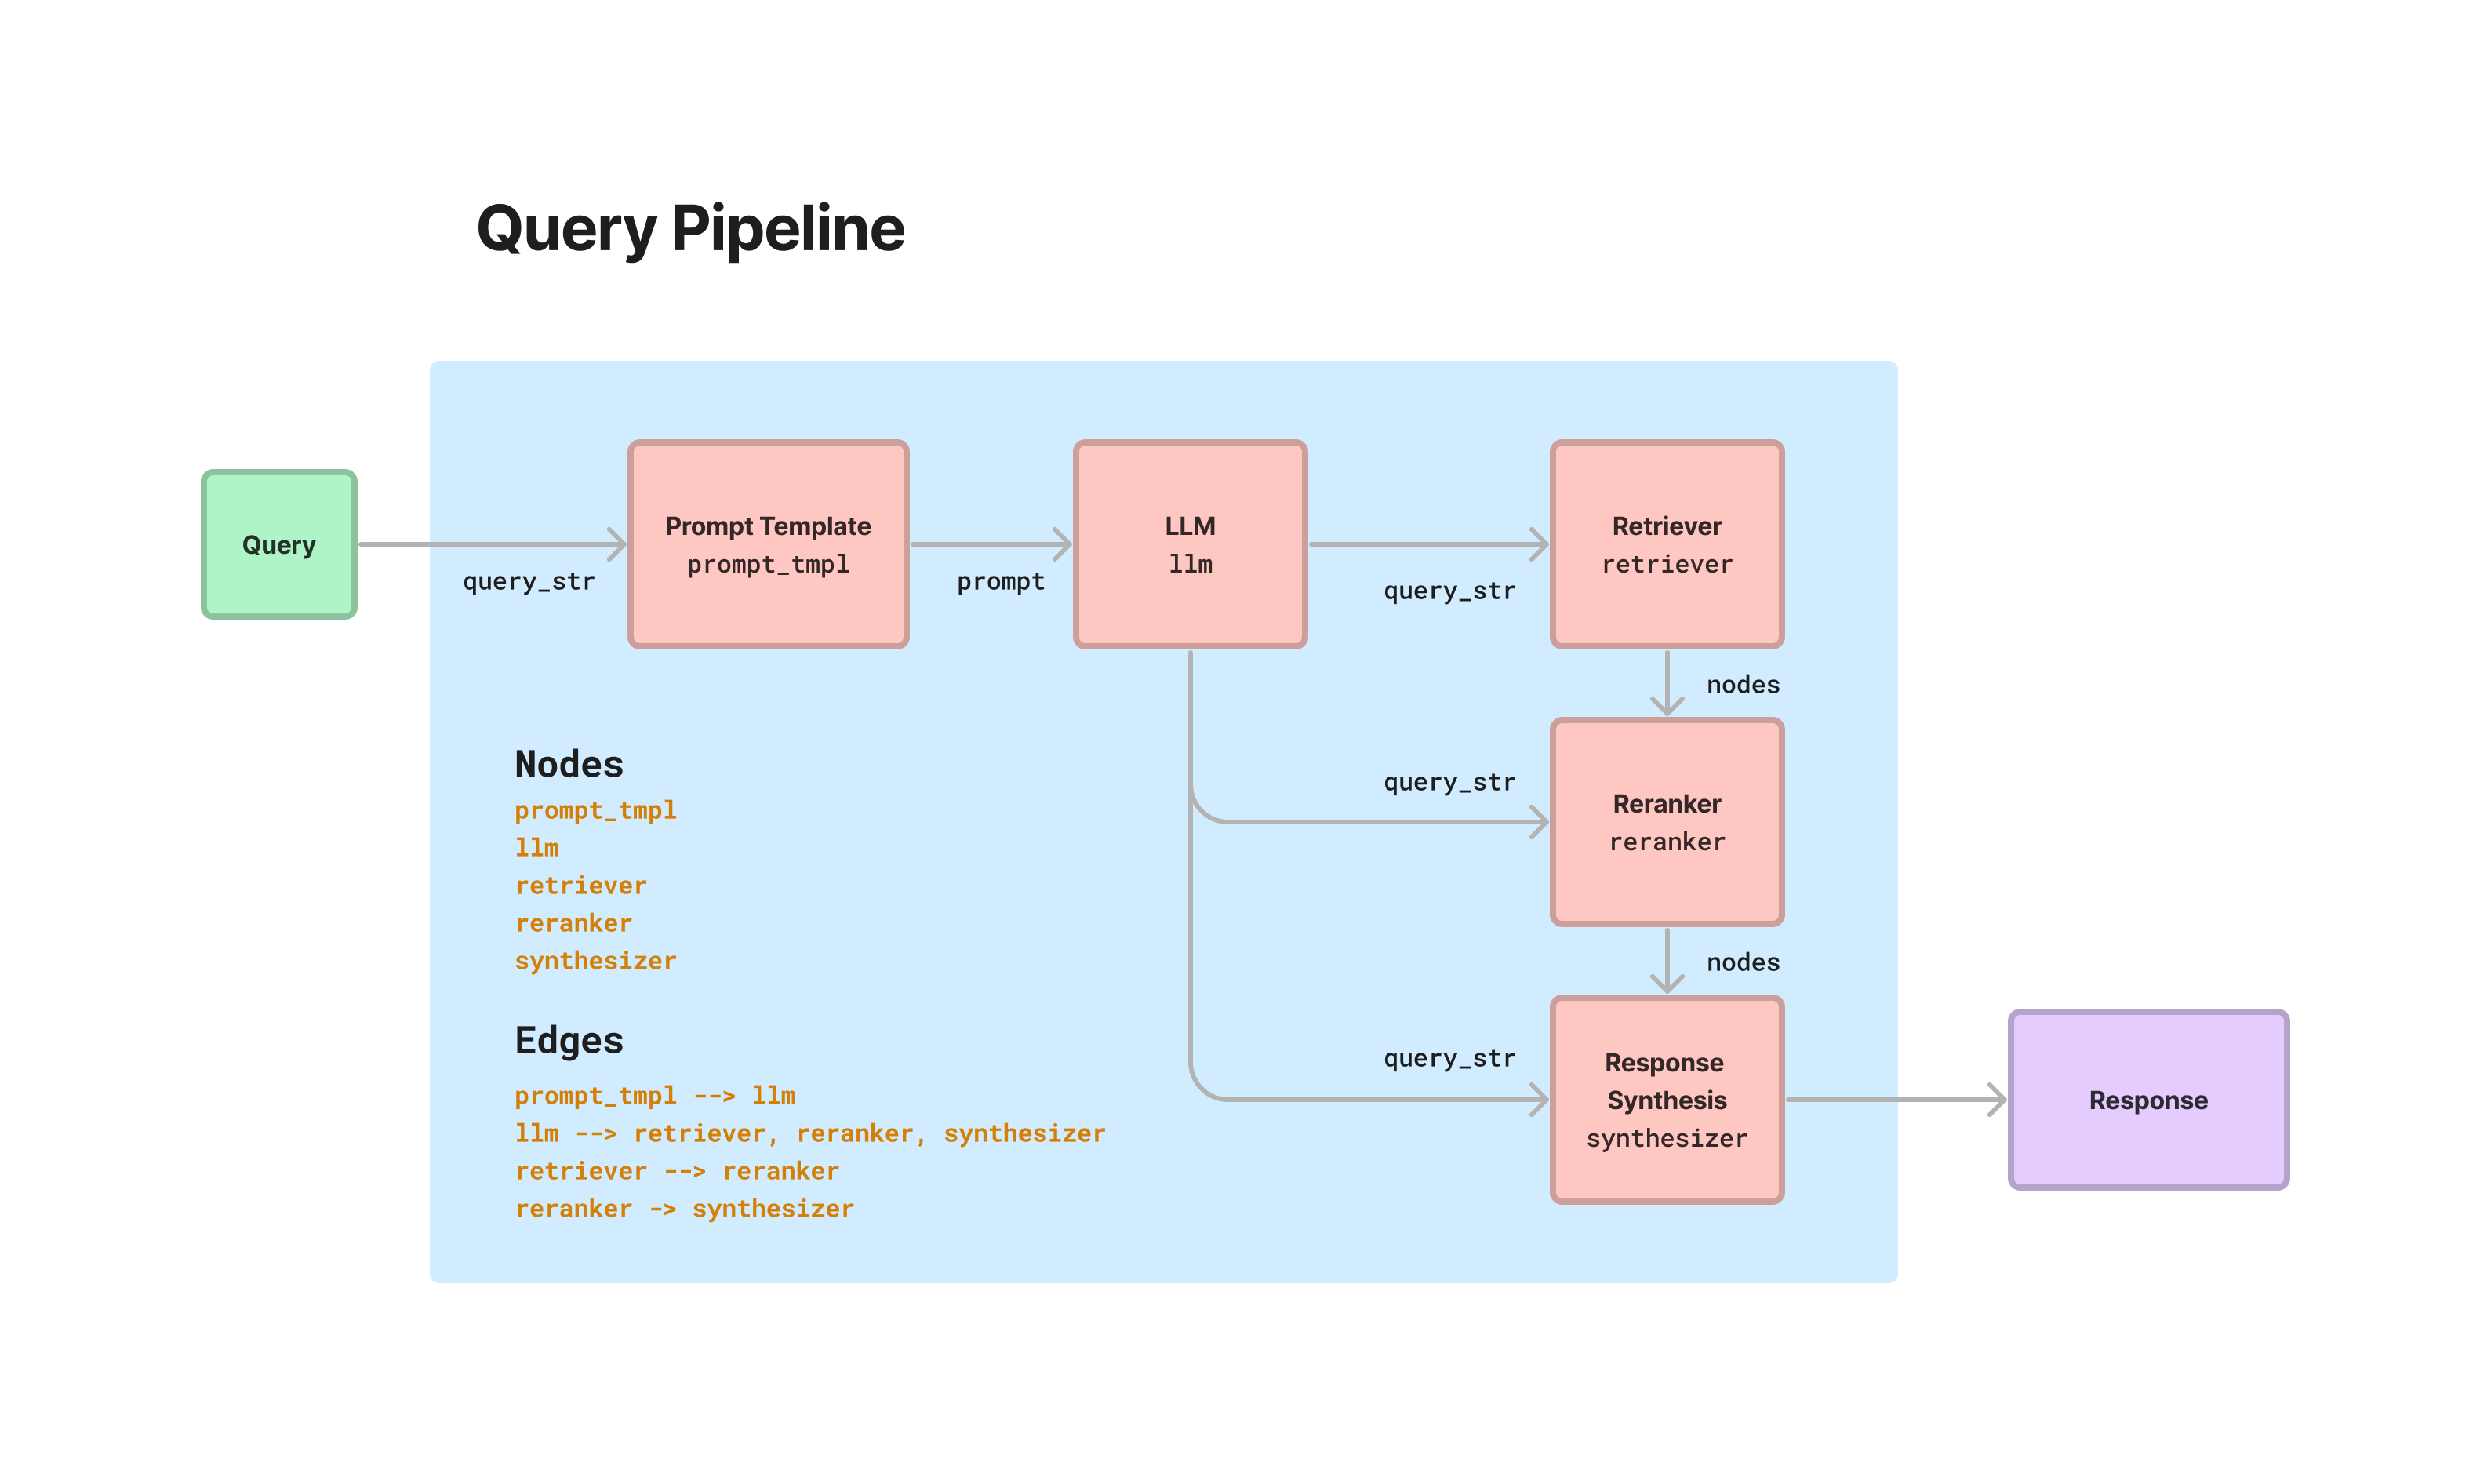


In [21]:
from llama_index.core.query_pipeline import QueryPipeline
from llama_index.core import PromptTemplate
from llama_index.core.response_synthesizers import TreeSummarize

# define modules
prompt_str = "Please look for research gaps regarding the following topic {topic}"
prompt_tmpl = PromptTemplate(prompt_str)
retriever = index.as_retriever(similarity_top_k=3)
summarizer = TreeSummarize(llm=llm)

# define query pipeline
p = QueryPipeline(verbose=True)
p.add_modules(
    {
        "llm": llm,
        "prompt_tmpl": prompt_tmpl,
        "retriever": retriever,
        "summarizer": summarizer,
        
    }
)
p.add_link("prompt_tmpl", "retriever")
p.add_link("llm", "retriever")
p.add_link("retriever", "llm", )


In [22]:
from IPython.display import display, Markdown

#output = p.run(topic="code smells")
output, intermediates = p.run_with_intermediates(movie_name="test smells")

display(str(output))


ValueError: Only one root is supported.